In [ ]:
import os
import sys
from pathlib import Path

import pandas as pd
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image as IPImage
from torchvision import transforms
import torch

# Add project src, utils directories to path
sys.path.append(str((Path().resolve() / '../src').resolve()))
sys.path.append(str((Path().resolve() / '../utils').resolve()))

# Custom/project-specific imports
from config import GROUP_MAP, RESULTS_DIR, SHOES_CATEGORIES, CLOTHING_CATEGORIES, BAGS_CATEGORIES, IMAGE_SIZE, DATA_DIR
from model import EfficientNetClassifier
from utils import load_model

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
test_samples = [
    # Bags
    {"path": DATA_DIR / 'test_samples' / 'bags_1.jpg', "group": "Bags", "subcat": "Clutches"},
    {"path": DATA_DIR / 'test_samples' / 'bags_2.jpg', "group": "Bags", "subcat": "Clutches"},
    {"path": DATA_DIR / 'test_samples' / 'bags_3.jpg', "group": "Bags", "subcat": "Clutches"},
    {"path": DATA_DIR / 'test_samples' / 'bags_4.jpg', "group": "Bags", "subcat": "Clutches"},
    {"path": DATA_DIR / 'test_samples' / 'bags_6.jpg', "group": "Bags", "subcat": "Handbags"},
    {"path": DATA_DIR / 'test_samples' / 'bags_7.jpg', "group": "Bags", "subcat": "Handbags"},
    {"path": DATA_DIR / 'test_samples' / 'bags_11.jpg', "group": "Bags", "subcat": "Wallets"},
    {"path": DATA_DIR / 'test_samples' / 'bags_12.jpg', "group": "Bags", "subcat": "Wallets"},
    {"path": DATA_DIR / 'test_samples' / 'bags_13.jpg', "group": "Bags", "subcat": "Wallets"},
    {"path": DATA_DIR / 'test_samples' / 'bags_14.jpg', "group": "Bags", "subcat": "Wallets"},
    # Shoes
    {"path": DATA_DIR / 'test_samples' / 'shoes_2.jpg', "group": "Shoes", "subcat": "Flats"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_3.jpg', "group": "Shoes", "subcat": "Flats"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_5.jpg', "group": "Shoes", "subcat": "Flats"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_6.jpg', "group": "Shoes", "subcat": "Heels"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_7.jpg', "group": "Shoes", "subcat": "Heels"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_8.jpg', "group": "Shoes", "subcat": "Heels"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_12.jpg', "group": "Shoes", "subcat": "Sports Shoes"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_13.jpg', "group": "Shoes", "subcat": "Sports Shoes"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_14.jpg', "group": "Shoes", "subcat": "Casual Shoes"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_15.jpg', "group": "Shoes", "subcat": "Casual Shoes"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_16.jpg', "group": "Shoes", "subcat": "Casual Shoes"},
    {"path": DATA_DIR / 'test_samples' / 'shoes_17.jpg', "group": "Shoes", "subcat": "Casual Shoes"},
    # Clothing
    {"path": DATA_DIR / 'test_samples' / 'clothing_1.jpg', "group": "Clothing", "subcat": "Dresses"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_2.jpg', "group": "Clothing", "subcat": "Dresses"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_3.jpg', "group": "Clothing", "subcat": "Dresses"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_4.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_5.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_6.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_7.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_8.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_9.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_10.jpg', "group": "Clothing", "subcat": "Outerwear"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_11.jpg', "group": "Clothing", "subcat": "Skirts"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_12.jpg', "group": "Clothing", "subcat": "Skirts"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_13.jpg', "group": "Clothing", "subcat": "Skirts"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_15.jpg', "group": "Clothing", "subcat": "Skirts"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_16.jpg', "group": "Clothing", "subcat": "Skirts"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_17.jpg', "group": "Clothing", "subcat": "Dresses"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_18.jpg', "group": "Clothing", "subcat": "Dresses"},
    {"path": DATA_DIR / 'test_samples' / 'clothing_19.jpg', "group": "Clothing", "subcat": "Dresses"},
]

In [3]:
existing_files = set(os.listdir(DATA_DIR / 'test_samples'))

missing = []
test_samples_filtered = []
for sample in test_samples:
    fname = sample["path"].name if hasattr(sample["path"], "name") else os.path.basename(str(sample["path"]))
    if fname in existing_files:
        test_samples_filtered.append(sample)
    else:
        missing.append(fname)

print("Missing files:", missing)
print(f"Total valid test samples: {len(test_samples_filtered)}")

Missing files: []
Total valid test samples: 40


In [4]:
GROUP_MODEL_PATH = RESULTS_DIR / 'model_group_classifier.pth'
SHOES_MODEL_PATH = RESULTS_DIR / 'model_shoes_classifier.pth'
CLOTHING_MODEL_PATH = RESULTS_DIR / 'model_clothing_classifier.pth'
BAGS_MODEL_PATH = RESULTS_DIR / 'model_bags_classifier.pth'


target_categories = list(GROUP_MAP.keys())

GROUP_CLASSES = sorted(list(set(GROUP_MAP.values())))
SHOES_CLASSES = SHOES_CATEGORIES
CLOTHING_CLASSES = CLOTHING_CATEGORIES
BAGS_CLASSES = BAGS_CATEGORIES

In [5]:
group_model = EfficientNetClassifier(num_classes=len(GROUP_CLASSES)).to(device)
group_model = load_model(group_model, GROUP_MODEL_PATH)

/Users/hossein/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hossein/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def infer_pipeline(image_path):
    img = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor()
    ])
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    group_model.eval()
    with torch.no_grad():
        out = group_model(img_tensor)
        group_idx = out.argmax(1).item()
        group_label = GROUP_CLASSES[group_idx]
    
    if group_label == "Shoes":
        shoes_model = EfficientNetClassifier(num_classes=len(SHOES_CLASSES)).to(device)
        shoes_model = load_model(shoes_model, SHOES_MODEL_PATH)
        shoes_model.eval()
        with torch.no_grad():
            out = shoes_model(img_tensor)
            sub_idx = out.argmax(1).item()
            sub_label = SHOES_CLASSES[sub_idx]
    elif group_label == "Clothing":
        clothing_model = EfficientNetClassifier(num_classes=len(CLOTHING_CLASSES)).to(device)
        clothing_model = load_model(clothing_model, CLOTHING_MODEL_PATH)
        clothing_model.eval()
        with torch.no_grad():
            out = clothing_model(img_tensor)
            sub_idx = out.argmax(1).item()
            sub_label = CLOTHING_CLASSES[sub_idx]
    else:
        bags_model = EfficientNetClassifier(num_classes=len(BAGS_CLASSES)).to(device)
        bags_model = load_model(bags_model, BAGS_MODEL_PATH)
        bags_model.eval()
        with torch.no_grad():
            out = bags_model(img_tensor)
            sub_idx = out.argmax(1).item()
            sub_label = BAGS_CLASSES[sub_idx]
    return group_label, sub_label

In [ ]:
# Run inference and collect results
results = []
for sample in test_samples:
    pred_group, pred_subcat = infer_pipeline(sample["path"])
    results.append({
        "file": os.path.basename(sample["path"]),
        "true_group": sample["group"],
        "pred_group": pred_group,
        "true_subcat": sample["subcat"],
        "pred_subcat": pred_subcat,
        "group_correct": pred_group == sample["group"],
        "subcat_correct": pred_subcat == sample["subcat"]
    })

In [8]:
# Calculate accuracy
group_stats = defaultdict(int)
subcat_stats = defaultdict(int)
for res in results:
    group_stats["total"] += 1
    if res["group_correct"]:
        group_stats["correct"] += 1
    if res["subcat_correct"]:
        subcat_stats["correct"] += 1

group_acc = group_stats['correct'] / group_stats['total']
subcat_acc = subcat_stats['correct'] / group_stats['total']

print("=== Group classification accuracy ===")
print(f"{group_stats['correct']} / {group_stats['total']} correct ({group_acc:.2%})")
print("=== Subcategory classification accuracy ===")
print(f"{subcat_stats['correct']} / {group_stats['total']} correct ({subcat_acc:.2%})")

=== Group classification accuracy ===
27 / 40 correct (67.50%)
=== Subcategory classification accuracy ===
13 / 40 correct (32.50%)


In [ ]:
# Display results as a table
df_eval = pd.DataFrame(results)
display(df_eval)

,file,true_group,pred_group,true_subcat,pred_subcat,group_correct,subcat_correct
0,bags_1.jpg,Bags,Bags,Clutches,Handbags,True,False
1,bags_2.jpg,Bags,Clothing,Clutches,Dresses,False,False
2,bags_3.jpg,Bags,Bags,Clutches,Clutches,True,True
3,bags_4.jpg,Bags,Bags,Clutches,Clutches,True,True
4,bags_6.jpg,Bags,Bags,Handbags,Handbags,True,True
5,bags_7.jpg,Bags,Bags,Handbags,Handbags,True,True
6,bags_11.jpg,Bags,Bags,Wallets,Wallets,True,True
7,bags_12.jpg,Bags,Clothing,Wallets,Dresses,False,False
8,bags_13.jpg,Bags,Clothing,Wallets,Skirts,False,False
9,bags_14.jpg,Bags,Bags,Wallets,Wallets,True,True


In [ ]:
df_eval.to_csv(RESULTS_DIR / 'manual_inference_eval_results.csv', index=False)

In [ ]:
group_acc = df_eval['group_correct'].mean()
subcat_acc = df_eval['subcat_correct'].mean()
print(f"Group Accuracy: {group_acc:.2%}")
print(f"Subcategory Accuracy: {subcat_acc:.2%}")

Group Accuracy: 67.50%
Subcategory Accuracy: 32.50%


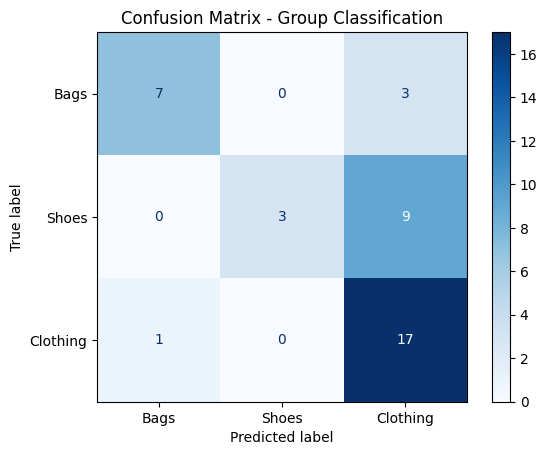

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# For group classification
cm_group = confusion_matrix(df_eval['true_group'], df_eval['pred_group'], labels=df_eval['true_group'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_group,
                             display_labels=df_eval['true_group'].unique())
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Group Classification")
plt.show()

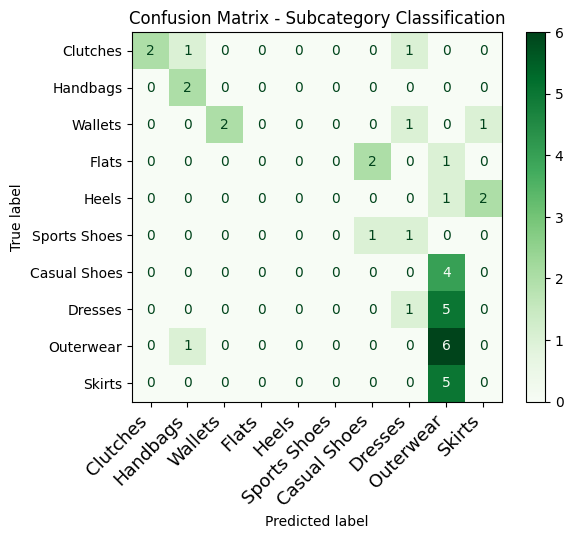

In [ ]:
# For subcategory classification
cm_subcat = confusion_matrix(df_eval['true_subcat'], df_eval['pred_subcat'], labels=df_eval['true_subcat'].unique())
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_subcat,
                              display_labels=df_eval['true_subcat'].unique())
disp2.plot(cmap="Greens", values_format='d')
plt.title("Confusion Matrix - Subcategory Classification")
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.show()